In [1]:
import os , csv
from tools.import_data import *

In [2]:
from sklearn import model_selection
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn import feature_selection as fs
from sklearn.preprocessing import LabelEncoder
import pandas
import matplotlib.pyplot as plt

In [3]:
#Selecting Models
models = []
models.append(('LR', LogisticRegression()))
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

In [4]:
def train_the_data(X_train,Y_train,models):
    # Spot Check Algorithms with cross validation
    # evaluate each model in turn
    scoring = 'accuracy'
    scores = []
    names = []
    results = []
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10)
        cv_results = model_selection.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        scores.append(cv_results)
        names.append(name)
        results.append({"name":name,"score":cv_results.mean()})
        msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(msg)
    # Compare Algorithms
    fig = plt.figure()
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot(scores)
    ax.set_xticklabels(names)
    plt.show()
    return 
    # arr = []
    # for i in range(10):
    #     arr.append({"name":i,"num":i*10})
    # m = max([k["num"] for k in arr])
    # i = [k["num"] for k in arr].index(m)
    # name = arr[i]["name"]
    # print (name , m)

In [5]:
def test_the_data(X_train,Y_train,X_test,Y_test,models):
    # Make predictions on test dataset
    scoring = []
    for name, model in models:
        model.fit(X_train, Y_train)
        predictions = model.predict(X_test)
        print('Model ' , name)
        print('Accuracy: ', accuracy_score(Y_test, predictions))
        #print(confusion_matrix(Y_validation, predictions))
        print(classification_report(Y_test, predictions))
        return 
    # 
    # encoder(predict_dataset)
    # #print (predict_dataset)
    # predict=predict_dataset.values[:,0:22]
    # 
    # predictions = lr.predict(predict)
    
    # temp = pandas.DataFrame(predict)
    # temp['class'] = predictions
    # temp.to_csv('predict.csv')

In [7]:
if __name__ == "__main__":
    X_train, Y_train ,names_train = load_dataset(os.path.join('D:/motybz/Cancer_Data_Mining/trin-SD01/trin-SD01.csv'))
    X_test, Y_test ,names_test = load_dataset(os.path.join('D:/motybz/Cancer_Data_Mining/trin-SD01/test-SD01.csv'))
    print ('Train data shape: ', X_train.shape)
    print ('Train labels shape: ', Y_train.shape)
    print ('Test data shape: ', X_test.shape)
    print ('Test labels shape: ', Y_test.shape)

Train data shape:  (92, 418976)
Train labels shape:  (92,)
Test data shape:  (88, 418976)
Test labels shape:  (88,)


In [8]:
    # #before we found the elbow
    # new_shape = []
    # range = np.arange(0.0, 0.1, 0.001)
    # for VTHRESH in range  :  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # 
    # plt.plot(range, new_shape)


In [9]:
    # #after we found the elbow
    # new_shape = []
    # range = np.arange(0.04, 0.17, 0.001)
    # for VTHRESH in range:  
    #     sel = fs.VarianceThreshold(VTHRESH)
    #     x = sel.fit_transform(X_train)
    #     new_shape.append(x.shape[-1])
    # plt.plot(range, new_shape)

LR: 0.714444 (0.168512)


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


LDA: 0.626667 (0.137005)


KNN: 0.582222 (0.161414)


CART: 0.608889 (0.187564)


NB: 0.617778 (0.115812)


SVM: 0.541111 (0.143505)


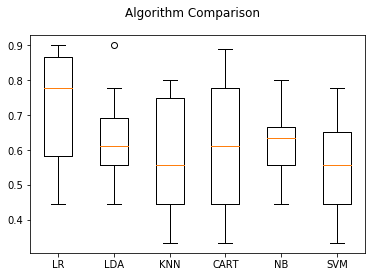

In [11]:
    train_the_data(X_train,Y_train,models)

In [11]:
    test_the_data(X_train,Y_train,X_test,Y_test,models)

Model  LR
Accuracy:  0.7840909090909091
             precision    recall  f1-score   support

        "0"       0.43      0.17      0.24        18
        "1"       0.81      0.94      0.87        70

avg / total       0.74      0.78      0.74        88



C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\discriminant_analysis.py:388: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")


Model  LDA
Accuracy:  0.26136363636363635
             precision    recall  f1-score   support

        "0"       0.21      0.94      0.34        18
        "1"       0.86      0.09      0.16        70

avg / total       0.72      0.26      0.19        88



Model  KNN
Accuracy:  0.5454545454545454
             precision    recall  f1-score   support

        "0"       0.19      0.39      0.26        18
        "1"       0.79      0.59      0.67        70

avg / total       0.67      0.55      0.59        88



Model  CART
Accuracy:  0.36363636363636365
             precision    recall  f1-score   support

        "0"       0.20      0.72      0.32        18
        "1"       0.79      0.27      0.40        70

avg / total       0.67      0.36      0.39        88



Model  NB
Accuracy:  0.3068181818181818
             precision    recall  f1-score   support

        "0"       0.21      0.89      0.34        18
        "1"       0.85      0.16      0.27        70

avg / total       0.72      0.31      0.28        88



Model  SVM
Accuracy:  0.20454545454545456
             precision    recall  f1-score   support

        "0"       0.20      1.00      0.34        18
        "1"       0.00      0.00      0.00        70

avg / total       0.04      0.20      0.07        88



C:\Users\motybz\Anaconda3\envs\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
